In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
allimage = os.listdir('/content/drive/MyDrive/Project/flickr8/Images')
data = pd.read_csv('/content/drive/MyDrive/Project/flickr8/captions.txt', sep=',', header=None, names=['image', 'caption'])
data.image = data.image.apply( lambda x: x.split('jpg')[0]+'jpg')
data['avail'] = data.image.apply( lambda x: x in allimage)
data = data[ data.avail==True]
data = data.dropna()
print(data.shape)
data.head()

(40455, 3)


,image,caption,avail
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,True
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,True
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,True
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,True
5,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,True


In [ ]:
import gc
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
word_counter = defaultdict(int)

table = str.maketrans('', '', string.punctuation,)
def preprocesCaption( caption):
  caption = caption.lower() #to lower case
  caption = caption.translate(table) #remove punctuations
  caption = caption.split() # convert to words
  caption = [ w for w in caption if len(w) > 1 ] #remove dangling 'a' and 's'
  caption = [ w for w in caption if w.isalpha()  ] #keep only words with alphabets
  caption = [ lemmatizer.lemmatize(w) for w in caption ]
  for w in caption: word_counter[w]+=1
  return ' '.join(caption)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


100%|██████████| 8091/8091 [00:29<00:00, 278.42it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


8091 1748


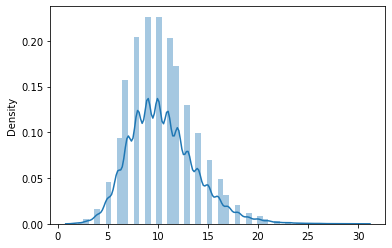

In [ ]:
from collections import defaultdict

words = set()
words.update( ('<S>','</S>') )
mx = []

images = defaultdict(list)
for img in tqdm(data.image.unique()):
    for comment in data[data.image == img ].caption.values:
        caption = preprocesCaption(comment)
        caption = [ w for w in caption.split() if word_counter[w]>=10 ]  #taking words whose count atleast 10
        words.update( caption )
        mx.append( len(caption)+2 )
        images[img].append( '<S> '+" ".join(caption)+' </S>' )
        
print(len(images), len(words))
del data; gc.collect()
sns.distplot(mx)

In [ ]:
ind_to_word = {}
word_to_ind = {}

for i, w in enumerate(words):
  ind_to_word[i+1] = w
  word_to_ind[w] = i+1

In [ ]:
from keras.preprocessing.sequence import pad_sequences
images_caption = defaultdict(list)
MAX_SEQ_LEN = 17
VOCAB_SIZE = len(words)+1

for img in images.keys():
  arr = []
  for caption in images[img]:
    arr.append([word_to_ind.get(word) for word in caption.split() ])
  images_caption[img] = arr

In [ ]:
embeddings = np.zeros(shape=(VOCAB_SIZE, 50))
with open('/content/drive/MyDrive/Project/golve6b50dtxt/glove.6B.50d.txt', 'r') as glov:
  for line in glov.readlines():
    line = line.split()
    if line[0] in words:
      embeddings[word_to_ind[line[0]]] = list(map(float, line[1:]))
embeddings.shape

(1749, 50)

In [ ]:
import random
data = []
for key in images_caption.keys():
  for caption in images_caption[key]:
    data.append((key, caption))
del images_caption; gc.collect()
data[:2]

[('1000268201_693b08cb0e.jpg', [325, 861]),
 ('1000268201_693b08cb0e.jpg', [325, 861])]

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
Xtext, Ximage, ytext = [], [], []
for image, text in tqdm(data):
  for i in range(1, len(text)):
    in_text, out_text = text[:i], text[i]
    in_text = pad_sequences([in_text], maxlen=MAX_SEQ_LEN, padding='pre').flatten()
    out_text = to_categorical(out_text, num_classes = VOCAB_SIZE)
    Xtext.append(in_text)
    Ximage.append(image)
    ytext.append(out_text)
Xtext = np.array(Xtext)
Ximage = np.array(Ximage)
ytext = np.array(ytext)
print(" {} {} {}" .format(Xtext.shape, Ximage.shape, ytext.shape))

100%|██████████| 40455/40455 [00:12<00:00, 3180.41it/s]


 (383850, 17) (383850,) (383850, 1749)


In [ ]:
from sklearn.model_selection import train_test_split
VALIDATION_SPLIT = 0.2
num_rec = int(len(ytext)*VALIDATION_SPLIT)
def split(dt, rec):
  return dt[:-1*rec], dt[-1*rec:]

Ttext, Vtext = split(Xtext, num_rec)
del Xtext; gc.collect()
Timage, Vimage = split(Ximage, num_rec)
del Ximage; gc.collect()
Ty, Vy = split(ytext, num_rec)
del ytext; gc.collect()
len(Ttext), len(Vtext)

(307080, 76770)

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.models import Model

IMG_DIM = (224, 224, 3)
vgg19 = VGG19(weights = 'imagenet', include_top=True, input_shape = IMG_DIM)
vgg19.layers.pop()
vggModel = Model( vgg19.input, vgg19.layers[-1].output)
imagemap = {}

def getImageFeature(path):
  temp = preprocess_input( img_to_array( load_img( os.path.join(path), target_size = IMG_DIM[:2])))
  return vggModel.predict(np.expand_dims(temp, axis=0))[0]

for img in tqdm(list(set(np.append(Timage, Vimage)))):
  imagemap[img] = getImageFeature('/content/drive/MyDrive/Project/flickr8/Images/' + img)

574726144/574710816 [==============================] - 4s 0us/step


100%|██████████| 8091/8091 [2:20:42<00:00,  1.04s/it]


In [ ]:
Timages = np.array([ imagemap[img] for img in Timage])
del Timage; gc.collect()
Vimages = np.array([ imagemap[img] for img in Vimage])
Timages.shape, Vimages.shape

((307080, 1000), (76770, 1000))

In [ ]:
from keras.layers import LSTM, Dense, Input, Embedding, add
from keras.models import Model
from keras.initializers import Constant

EMBEDDING_DIM = 50

inp_img = Input( shape=(1000,) ) 
feature_img = Dense(256,activation='relu',name="ImageFeature")(inp_img)

input_txt = Input(shape=(MAX_SEQ_LEN,))
ftxt = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, 
                 embeddings_initializer=Constant(embeddings),
                 trainable=False)(input_txt)
ftxt = LSTM(256,name="CaptionFeature")(ftxt)

decoder = add([ftxt,feature_img])
decoder = Dense(256,activation='relu')(decoder)
output = Dense(VOCAB_SIZE,activation='softmax')(decoder)

model = Model(inputs=[inp_img, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 17, 50)       87450       input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          314368      embedding[0][0]                  
____________________________________________________________________________________________

In [ ]:
hist = model.fit([Timages,Ttext], Ty, epochs=4, verbose=1, batch_size=64, validation_data=([Vimages,Vtext],Vy))

Epoch 1/4
4799/4799 [==============================] - 495s 100ms/step - loss: 4.2462 - val_loss: 3.6284
Epoch 2/4
4799/4799 [==============================] - 480s 100ms/step - loss: 3.1789 - val_loss: 3.4990
Epoch 3/4
4799/4799 [==============================] - 479s 100ms/step - loss: 2.9100 - val_loss: 3.5485
Epoch 4/4
4799/4799 [==============================] - 480s 100ms/step - loss: 2.7395 - val_loss: 3.6300


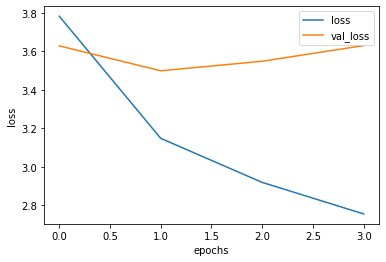

In [ ]:
for label in ["loss", "val_loss"]:
  plt.plot(hist.history[label], label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
!bash download_dev.sh

bash: download_dev.sh: No such file or directory


In [ ]:
def getNextWords(image, in_text, n=1):
  sequence = [word_to_ind[w] for w in in_text.split()]
  sequence = pad_sequences([sequence], MAX_SEQ_LEN)
  yhat = model.predict([image, sequence], verbose = 0)
  topn = yhat.argsort()[0][-1*n:][::-1]
  probs = yhat[0][topn]
  return [ (ind_to_word[i], p) for i, p in zip(topn, probs)]

In [ ]:
def predict_caption(image_path):
  image = np.expand_dims(getImageFeature(image_path), axis=0)
  in_text = '<S>'

  while i in range(MAX_SEQ_LEN):
    nw = getNextWords(image, in_text, n=1)[0][0]
    in_text = in_text + ' ' + nw
    if nw=="</S>":
      break
  return in_text
predict_caption('/content/drive/MyDrive/Project/Test/121697016-man-in-life-jacket-on-a-paddle-board-relax-on-the-paddle-board-the-concept-of-water-tourism-.jpg')

'<S> man in blue kayak is in the water </S>'

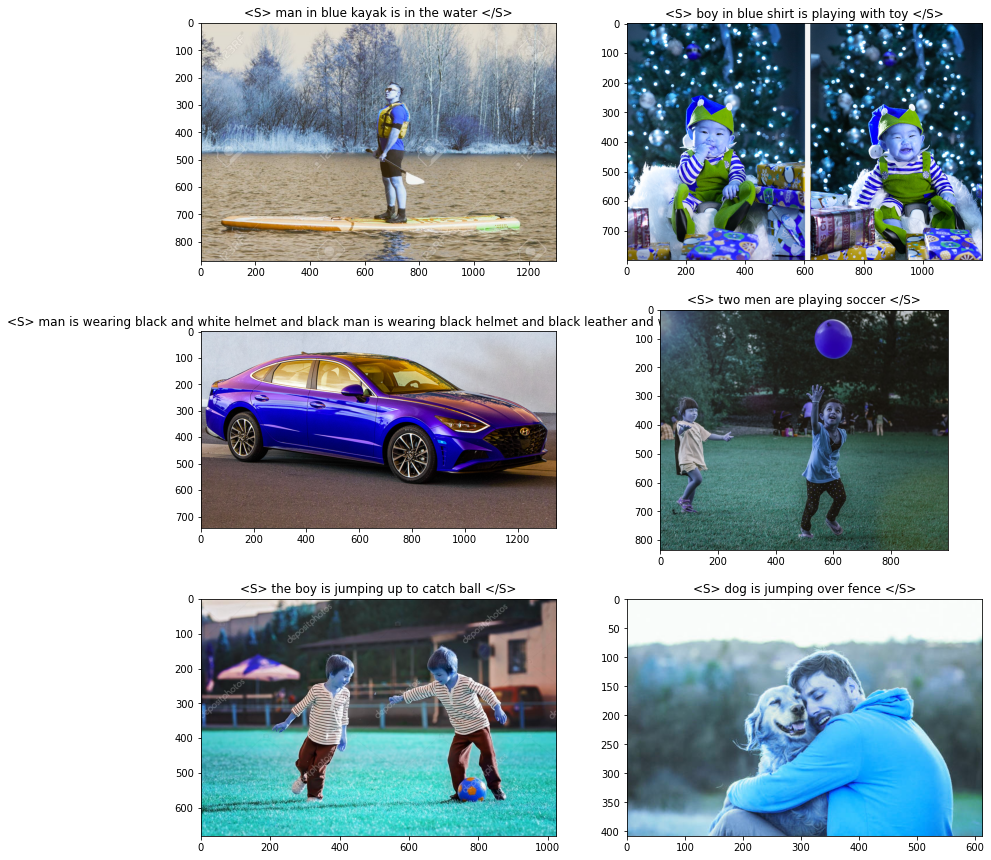

In [ ]:
import glob
import cv2

allimgs = glob.glob('/content/drive/MyDrive/Project/Test/*')
n = len(allimgs)

fig, ax = plt.subplots(nrows = (n//2)+n%2, ncols=2, figsize=(14, 15))
i=0

for img in allimgs:
  ax[i//2][i%2].imshow(cv2.imread(img))
  ax[i//2][i%2].set_title(predict_caption(img))
  i=i+1

In [ ]:
allimgs

['/content/drive/MyDrive/Project/Test/121697016-man-in-life-jacket-on-a-paddle-board-relax-on-the-paddle-board-the-concept-of-water-tourism-.jpg',
 '/content/drive/MyDrive/Project/Test/christmas-photography-tips-1.jpg',
 '/content/drive/MyDrive/Project/Test/SONATA-hero-option1-764A5360-edit.jpg',
 '/content/drive/MyDrive/Project/Test/photo-1516890896652-41ca1a35787c.jpg',
 '/content/drive/MyDrive/Project/Test/depositphotos_84192422-stock-photo-two-cute-little-boys-playing.jpg',
 '/content/drive/MyDrive/Project/Test/istockphoto-1204163981-612x612.jpg']

In [ ]:
def beam_search_caption(image_path, beam_length=2, topn=5):
  image = np.expand_dims(getImageFeature(image_path), axis=0)
  beam = [ (1, '<S>')]
  ans = []

  while len(beam)>0:
    cp, in_text = beam.pop(0)
    if len(in_text.split())>=MAX_SEQ_LEN:
      ans.append((cp, in_text))
      continue
    newwords = getNextWords(image, in_text, n=beam_length)

    for nw, prob in newwords:
      if nw=="</S>":
        ans.append((cp*prob, in_text+" "+nw))
      else:
        beam.append((cp*prob, in_text+" "+nw))
  return [x[1] for x in sorted(ans, key=lambda x:x[0], reverse=True)[:topn]]
beam_search_caption('/content/drive/MyDrive/Project/Test/121697016-man-in-life-jacket-on-a-paddle-board-relax-on-the-paddle-board-the-concept-of-water-tourism-.jpg')

['<S> man is in the water </S>',
 '<S> man is in boat </S>',
 '<S> person is in the water </S>',
 '<S> man is in the </S>',
 '<S> man is riding on boat </S>']

100%|██████████| 6/6 [43:23<00:00, 433.98s/it]


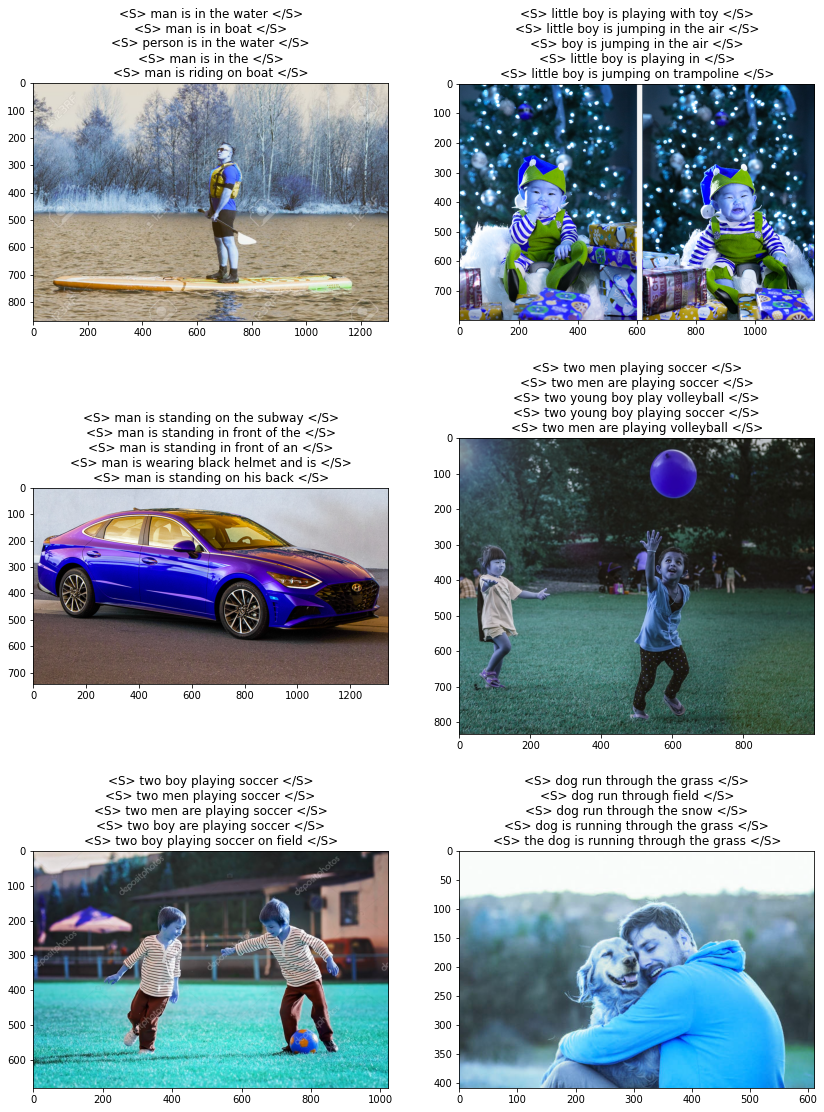

In [ ]:
fig,ax = plt.subplots(nrows=(n//2)+n%2,ncols=2,figsize=(14,20))
i=0
for img in tqdm(allimgs):
    ax[i//2][i%2].imshow(cv2.imread(img))
    ax[i//2][i%2].set_title("\n".join(beam_search_caption(img,beam_length=2,topn=5)))
    i+=1